In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

def generate_corr_stats(
    invcov,
    sampsize=100
):
    covmat = np.linalg.inv(invcov)
    samp = np.random.multivariate_normal([0,0,0],covmat,size=(sampsize,sampsize))
    
    sampcov=np.zeros((3,3,sampsize))
    sampcorr=np.zeros((3,3,sampsize))
    
    covvect=np.zeros((sampsize,6))
    invcovvect=np.zeros((sampsize,6))
    corrvect=np.zeros((sampsize,6))
    invcorrvect=np.zeros((sampsize,6))
    
    for i in range(sampsize):
        sampcov = np.cov(samp[:,i,:],rowvar=False)
        sampcorr = np.corrcoef(samp[:,i,:],rowvar=False)
        
        covvect[i,:] = sampcov[np.triu_indices(3)]
        invcovvect[i,:] = np.linalg.inv(sampcov)[np.triu_indices(3)]
        corrvect[i,:] = sampcorr[np.triu_indices(3)]
        invcorrvect[i,:] = np.linalg.inv(sampcorr)[np.triu_indices(3)]
        
    
    covvect=covvect.flatten()
    invcovvect=invcovvect.flatten()
    corrvect=corrvect.flatten()
    invcorrvect=invcorrvect.flatten()

    return covvect,invcovvect,corrvect,invcorrvect

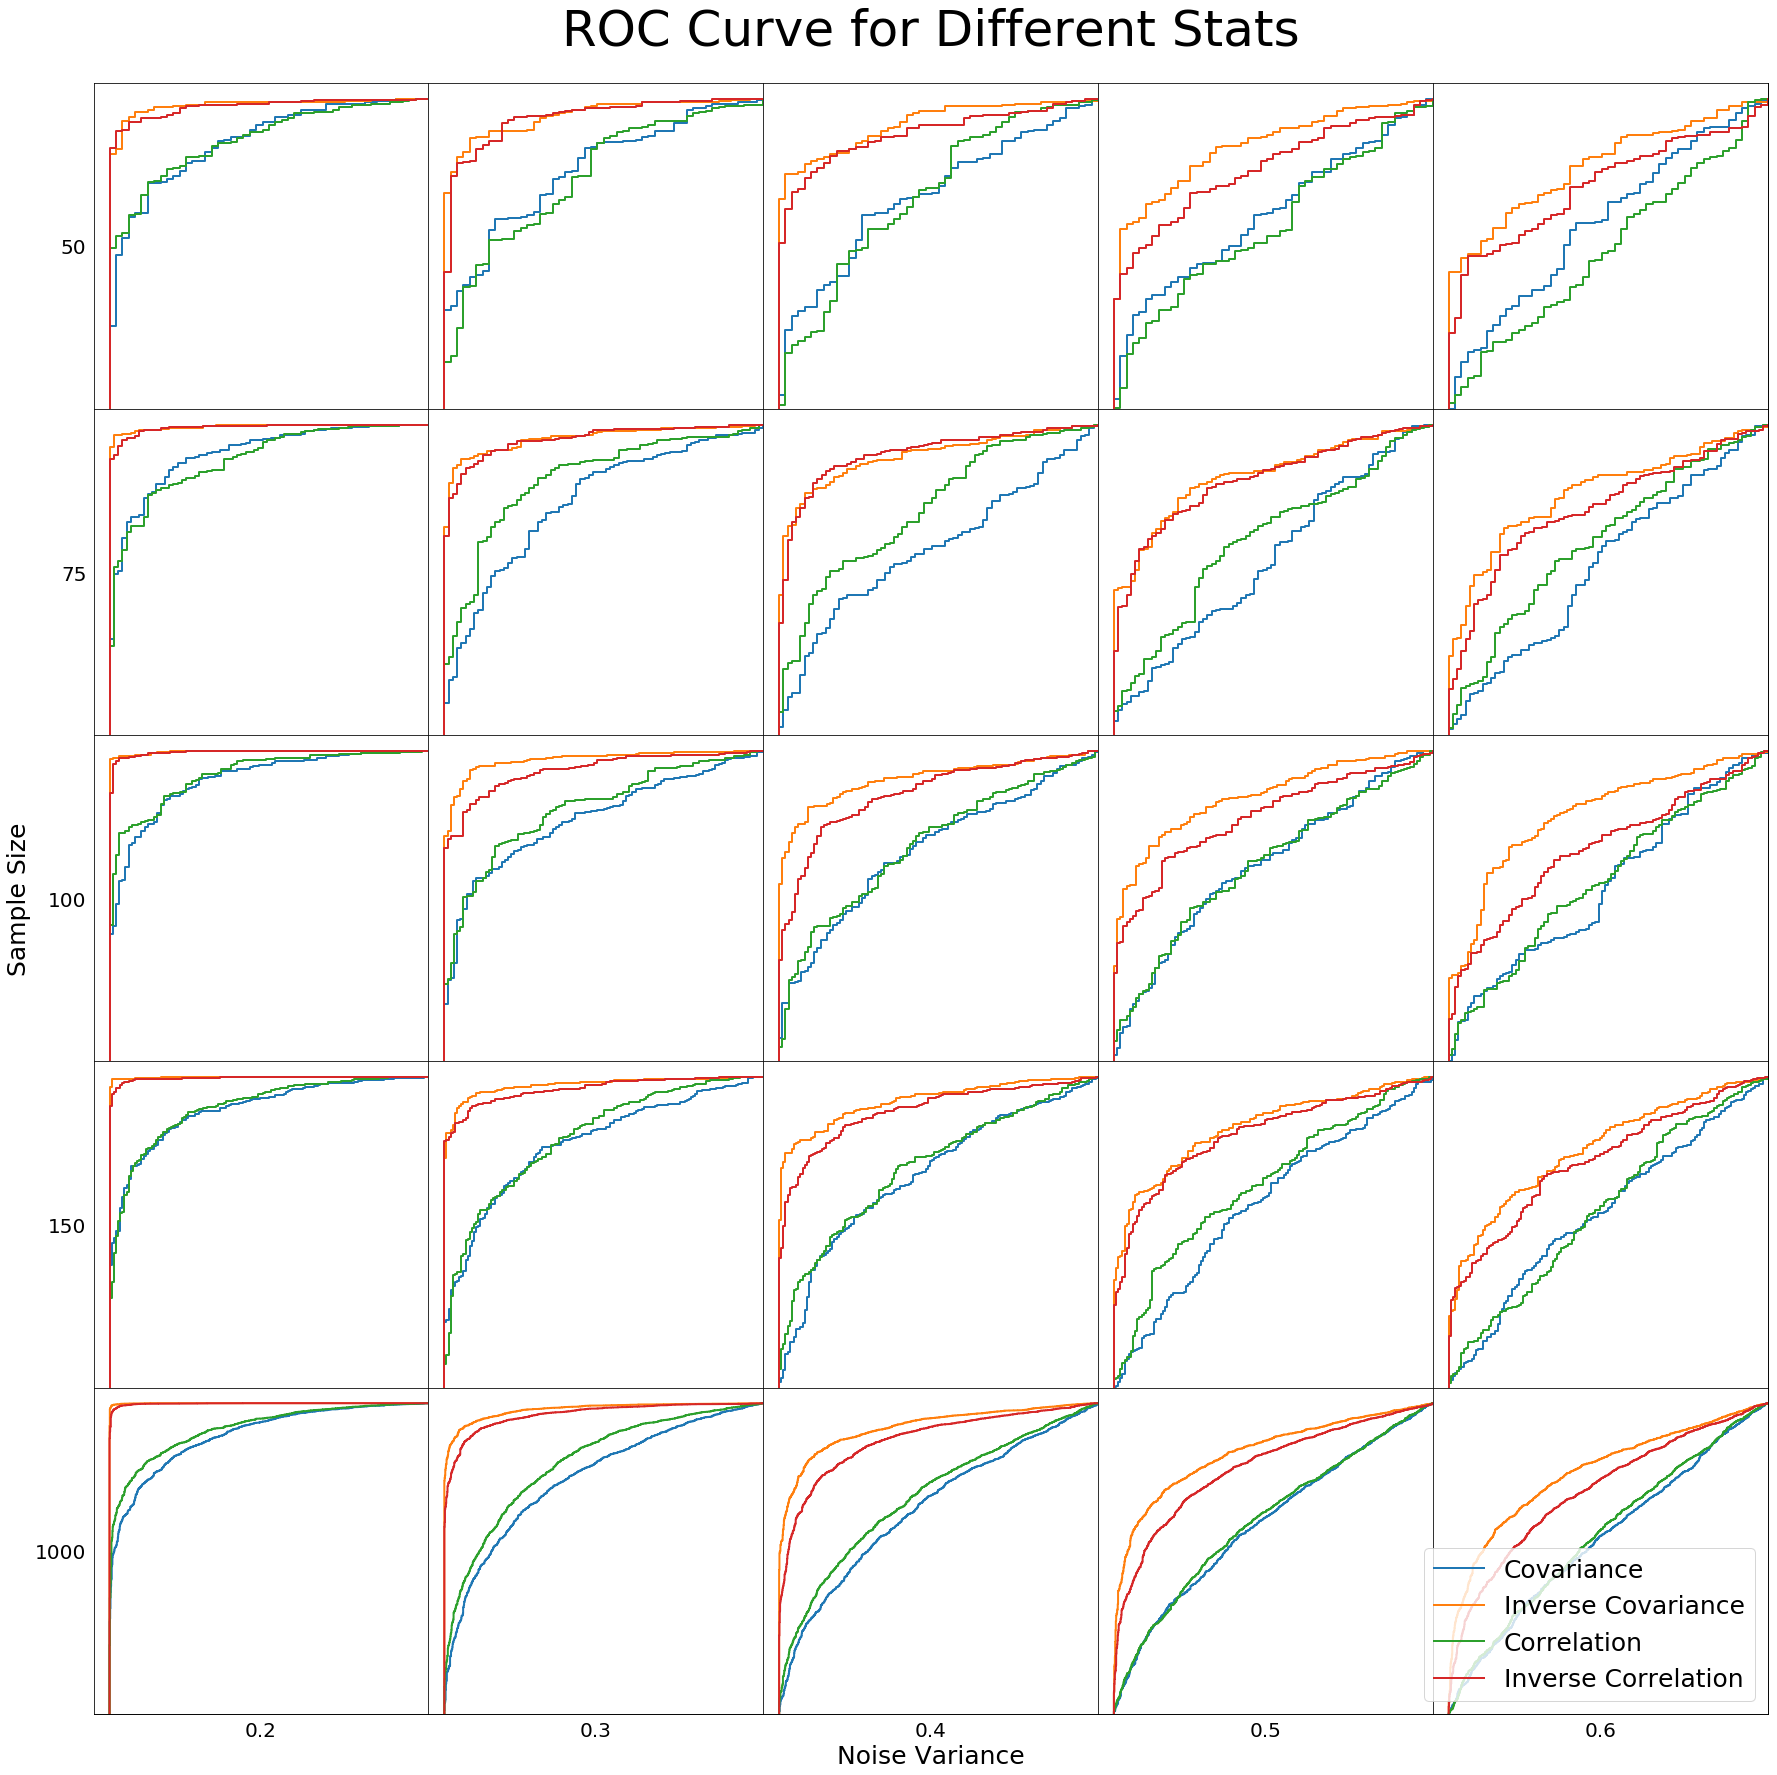

In [2]:
sampsize=[50,75,100,150,1000]
sigsq=[.2,.3,.4,.5,.6]
fig=plt.figure(figsize=(30,30))
lw = 2

precmat=np.array([[2,-1,0],[-1,2,-1],[0,-1,2]])
absprec=np.array([[1,1,0],[1,1,1],[0,1,1]])
absvect=absprec[np.triu_indices(3)]

fig.add_subplot(111)
plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,         
    left=False,
    right=False)
plt.yticks([.5,1.5,2.5,3.5,4.5,5],[1000,150,100,75,50,' '],fontsize=20)
plt.xticks([.5,1.5,2.5,3.5,4.5,5],[.2,.3,.4,.5,.6,' '],fontsize=20)
plt.grid(False)
plt.xlabel("Noise Variance",fontsize=25)
plt.ylabel("Sample Size",fontsize=25)
plt.title('ROC Curve for Different Stats',fontsize=50,y=1.02)

diffmat=np.zeros((5,5))

for i in range(5):
    
    absvec = np.tile(absvect,sampsize[i])
    cov,invcov,corr,invcorr = generate_corr_stats(precmat,sampsize[i])
    
    for j in range(5):

        cov=cov+np.random.normal(0,sigsq[j],6*sampsize[i])
        invcov=invcov+np.random.normal(0,sigsq[j],6*sampsize[i])
        corr=corr+np.random.normal(0,sigsq[j],6*sampsize[i])
        invcorr=invcorr+np.random.normal(0,sigsq[j],6*sampsize[i])

        fpr1,tpr1,_=metrics.roc_curve(absvec,np.absolute(cov),drop_intermediate=False)
        fpr2,tpr2,_=metrics.roc_curve(absvec,np.absolute(invcov),drop_intermediate=False)
        fpr3,tpr3,_=metrics.roc_curve(absvec,np.absolute(corr),drop_intermediate=False)
        fpr4,tpr4,_=metrics.roc_curve(absvec,np.absolute(invcorr),drop_intermediate=False)

        auc1=metrics.auc(fpr1, tpr1)
        auc2=metrics.auc(fpr2, tpr2)
        auc3=metrics.auc(fpr3, tpr3)
        auc4=metrics.auc(fpr4, tpr4)
        
        axes=fig.add_subplot(5,5,(i*5)+(j+1))
        axes.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False)
        axes.plot(fpr1, tpr1,
                 lw=lw, label='Covariance')
        axes.plot(fpr2, tpr2,
                 lw=lw, label='Inverse Covariance')
        axes.plot(fpr3, tpr3,
                 lw=lw, label='Correlation')
        axes.plot(fpr4, tpr4,
                 lw=lw, label='Inverse Correlation')
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        
        diffmat[i,j]=(auc2+auc4-auc1-auc3)/2
        
    
plt.legend(loc="lower right",fontsize=25)
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.show()

Text(86.0, 0.5, 'Sample Size')

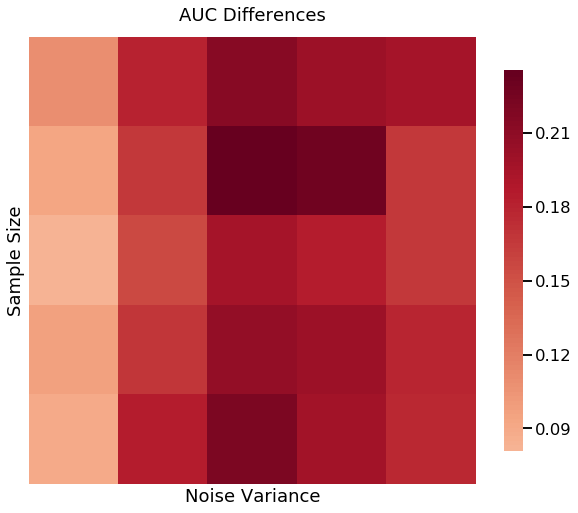

In [3]:
from graspy.plot import heatmap

fig=heatmap(diffmat,title='AUC Differences')
plt.xlabel("Noise Variance")
plt.ylabel("Sample Size")